## UFMG - Trabalho Prático 1 - Machine Learning

**Daniel Pimentel Kansaon**

<h2> Introdução</h2>

O trabalho consiste na aplicação de algoritmos supervisionados comparando ao todo 6 métodos:

- **Naive Bayes**: Apenas um experimento para servir de baseline.
- **Decision Tree**: Variar a altura máxima da árvore (incluindo permitir altura ilimitada) e mostrar os resultados graficamente.
- **SVM**: Avaliar os kernels linear, sigmoid, polinomial e RBF.
- **k-NN**: Variar o número k de vizinhos e mostrar os resultados graficamente.
- **Random Forest**: Variar o número de árvores e mostrar os resultados graficamente.
- **Gradient Tree Boosting**: Variar o número de iterações e mostrar os resultados graficamente.

Os métodos serão testados em um problema de classificação binária (0 - 1) de candidatos a exoplanetas encontrados pela sonda espacial Kepler da NASA. Um exoplaneta é um planeta fora do sistema solar (i.e. que não orbita o sol). A sonda primeiro identifica sinais de possíıveis exoplanetas, chamados de Kepler Object of Interest (KOI). Porém nem todos os KOIs são de fato exoplanetas, alguns se tratam de "Falsos Positivos" de origens diversas. A tarefa é então classificar os KOIs entre exoplanetas
confirmados e "Falsos Positivos". Cada observação corresponde a um KOI e as features são características estimadas de cada (possível) exoplaneta (tamanho, temperatura, features da estrela hospedeira, etc).

In [1]:
#Adicionando as referências que serão usadas durante o trabalho
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import StratifiedKFold
from sklearn import feature_selection
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib as mpl
import statistics
import multiprocessing

#Metodos
from sklearn import svm
from sklearn import neighbors #K-nn
from sklearn import ensemble #Random Forest
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.naive_bayes import MultinomialNB #Naive Bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree


In [2]:
# As constantes do projeto estão adicionadas aqui.

# Caminho arquivo com os dados
FILE_PATH = "koi_data.csv"

#Quantidade de folds que será utilizado para a etapa de Cross-Validation
K_FOLD = 5

#Coluna TARGET do arquivo CSV
TARGET = "koi_disposition"

#Coluna que possui o nome do KOI
COLUMN_KOI = "kepoi_name"

## Tratamento nos Dados

Como dito acima, cada observação realizada corresponde a um KOI e as features são características estimadas de cada (possível) exoplaneta (tamanho, temperatura, features da estrela hospedeira, etc).

Assim, nesta etapa serão realizados processamentos dos dados a fim de prepará-los para a execução dos algoritmos.

In [3]:
df = pd.read_csv(FILE_PATH)

# Imprime algumas informacoes basicas sobre os dados
print("Número de linhas: {}".format(df.shape[0]))
print("Número de colunas: {}".format(df.shape[1]))

# Cria a lista de features com base nas colunas do arquivo CSV
features = list(df.columns)

#Remove a coluna target pois ela que está querendo prever.
features.remove(TARGET)

#Remove a coluna de nome, pois não é necessária para a predição
features.remove(COLUMN_KOI)

Número de linhas: 5202
Número de colunas: 43


## Ajustando o Target (rótulos dos dados)

In [4]:
#Porcentagem de [False Positive e Confirmed]
display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)
df[TARGET] = (df[TARGET] == "CONFIRMED").astype(int)

,FALSE POSITIVE,CONFIRMED
koi_disposition (%),59.55,40.45


## Normalizando os Dados

Nesta etapa, será concentrado o esforço em analisar os dados visando a normalização.

**Observando os dados**

Ao observar a tabela abaixo é possível notar que os valores possuem uma grande variação. Ou seja, alguns campos da tabela possuem um grande valor, já outros, um valor bem menor. Isso pode gerar alguns problemas nos algoritmos, fazendo com que a qualidade do modelo fique prejudicada. Se pensarmos por exemplo na ideia do backpropagation que utiliza o gradiente descendente para os cálculos, sem a normalização, a complexidade para encontrar o mínimo aumentaria, necessitando de mais iterações do que o normal. A principal ideia da normalização é eliminar ruídos deixando os dados mais uniformementes distribuídos. Como observado na tabela abaixo, é necessário normalizar os dados a fim de deixá-los mais uniformementes distribuídos. A decisão de normalzar se deu pela diferença consideravelmente grande dos valores da tabela.

OBS: Para experiência, realizei o TP inicialmente sem a normalização. Com isso, observei que foi necessário um grande tempo para o treino do SVM, principalmente com kernel linear, com duração de mais de 4 horas. Após a normalização, foi possível executar em poucos minutos.

In [5]:
#Imprimindo os dados
print("Dados:")
with pd.option_context("max_columns", 12): # Limita o numero de cols mostradas
    display(df.head(20))

Dados:


,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,...,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,1,9.48804,0.146,2.95750,615.8,...,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,1,54.41838,0.586,4.50700,874.8,...,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,0,1.73695,1.276,2.40641,8079.2,...,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,1,2.52559,0.701,1.65450,603.3,...,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,0,7.36179,1.169,5.02200,233.7,...,-4.506,7.710,8.930,-4.537,7.713,8.948
5,K00757.01,1,16.06865,0.052,3.53470,4914.3,...,0.041,-0.015,0.044,0.005,0.030,0.031
6,K00001.01,1,2.47061,0.818,1.74319,14231.0,...,-0.009,-0.300,0.300,0.015,-0.270,0.270
7,K00010.01,1,3.52250,0.631,3.19843,9145.7,...,0.014,-0.013,0.020,-0.028,0.176,0.178
8,K00112.02,1,3.70921,0.051,2.63020,131.1,...,0.240,-0.150,0.290,0.160,-0.130,0.210
9,K00742.01,0,11.52145,2.483,3.63990,17984.0,...,0.009,-0.009,0.013,0.147,0.037,0.151


**Lógica para a normalização**

De maneira geral, a fórmula divide a média de cada feature pelo seu desvio padrão.

In [6]:
# Subtrai a media de cada feature
df[features] = df[features] - df[features].mean()

# Divide pelo desvio padrão
# O desvio padrão não pode ser zero. **Observação importante
df[features] = df[features] / df[features].std()

#Imprimindo os valores após a normalização
df_mean = df[features].mean().round(2).to_frame("Media")
df_std = df[features].std().round(2).to_frame("Desvio Padrão")
with pd.option_context("max_rows", 15):
    display(df_mean.join(df_std))


,Media,Desvio Padrão
koi_period,-0.0,1.0
koi_impact,-0.0,1.0
koi_duration,0.0,1.0
koi_depth,-0.0,1.0
koi_ror,-0.0,1.0
koi_srho,0.0,1.0
koi_prad,0.0,1.0
...,...,...
koi_fwm_pdeco,0.0,1.0
koi_dicco_mra,0.0,1.0


## Separação dos dados para a validação cruzada

Nessa parte são separados os dados com base nos folds(5) para a validação cruzada. A partir disto, os algoritmos irão usar essas partições para treino e teste.

In [7]:
#Criando os vetores de treino e validacao
x_train = []
y_train = []
x_validation = []
y_validation = []

#Selecionando as features
skb = feature_selection.SelectKBest(feature_selection.f_classif, 41)
skb = skb.fit(df[features], df[TARGET])

#separa o X (são os exemplos) e o Y é o rótulo [0 ou 1]
X = df
Y = df[TARGET]

#Aqui é feito a separação dos dados em K_FOLD = 5.
data_kfold = StratifiedKFold(n_splits=K_FOLD, shuffle=True)
data_kfold.get_n_splits(X, Y)


#Nessa parte é lido os folds e armazenado nas listas.
#Exemplo: x_train [ fold1, fold2, fold3, fold4, fold5 ]

for train_index, test_index in data_kfold.split(X, Y):
    x_train.append(skb.transform(df.loc[train_index, features]))
    x_validation.append(skb.transform(df.loc[test_index, features]))
    y_train.append(df.loc[train_index, TARGET])
    y_validation.append(df.loc[test_index, TARGET])    

## Métodos Comuns

Nesta parte são criados os métodos comuns que serão utilizados para gerar gráficos e plotar os resultados.

In [8]:
#Método para calcular as principais métricas dos classificadores
def calc_important_metrics(y_val, y_pred):    
    classes = ["False Positive", "Confirmed"]
    print(metrics.classification_report(y_val, y_pred, [0, 1], classes))    

In [9]:
#Método para plotar a curva ROC
def calc_roc(y_val, y_proba):
    fpr, tpr, _ = metrics.roc_curve(y_val, y_proba)

    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='royalblue',lw=2)
    plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.show()

In [10]:
#Plota o gráfico da acurácia no treino x acurácia na validação
def plot_accuracyXparams(vX, vYTrain, xYtest, label, xticks = []):    
    plt.plot(vX, vYTrain, 'r--', label="train")
    plt.plot(vX, xYtest, color='royalblue',lw=2, label="validation")
    plt.xlabel(label)
    plt.ylabel('Accuracy')
    plt.title('Parameters x Accuracy')
    plt.legend(loc='upper left')
    
    if(len(xticks) > 0):
        plt.xticks(vX, (xticks[0], xticks[1], xticks[2], xticks[3]))
        
    plt.show()    

In [11]:
def show_results(clf):       
    y_pred = []
    y_prob = []
    y_val = []

#Obtêm todos os valores da validação de cada FOLD para calcular as métricas
    for i in range(0, K_FOLD):   
        y_pred.extend(clf.predict(x_validation[i]))
        y_val.extend(y_validation[i])        
        y_prob.extend(clf.predict_proba(x_validation[i])[:, 1])
    
    #Plotando resultados            
    calc_important_metrics(y_val, y_pred)  
    calc_roc(y_val, y_prob)

## Resultados

Nesta etapa serão apresentados os resultados dos classificadores na tarefa de classificar os exoplanetas. Vale ressaltar que foi utilizado validação cruzada de 5 folds/partições. Além do mais, foram plotados gráficos apenas para os melhores parâmetros de cada algoritmo. Em cada seção é abordada um algoritmo em especial, onde são apresentados os resultados e os gráficos. Por fim, na última seção é feito um resumo geral dos resultados.

## 1 - Naive Bayes

O algoritmo Naive Bayes é o algoritmo mais simples abordado, sendo utilizado como baseline no trabalho. Abaixo temos os resultados. De maneira geral, o algoritmo apresentou uma acurácia de 91,7%. Como o algoritmo não é paramétrico, não foram variados parâmetros. Observando o resultado, nota-se que o problema não é complexo ou difícil de ser resolvido, pois esse algoritmo é bem simples e mesmo assim atingiu uma boa taxa de precisão.

In [12]:
def calc_naivebayes():
    train_acc = []
    val_acc = []
            
    gnb = GaussianNB()
    
    for i in range(0, K_FOLD):            
        gnb = gnb.fit(x_train[i], y_train[i]) #Treino
        train_acc.append(gnb.score(x_train[i], y_train[i]))
        val_acc.append(gnb.score(x_validation[i], y_validation[i]))      
          
    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))      
    
    return gnb

In [13]:
gnb = calc_naivebayes()

Média da Acurácia na treino: 0.917
Média da Acurácia na validação: 0.917
Desvio Padrão da Acurácia na treino: 0.00261
Desvio Padrão da Acurácia na validação: 0.00651


**1.1 - Gráficos - Naive Bayes**

                precision    recall  f1-score   support

False Positive       0.98      0.88      0.93      3098
     Confirmed       0.84      0.97      0.91      2104

     micro avg       0.92      0.92      0.92      5202
     macro avg       0.91      0.93      0.92      5202
  weighted avg       0.93      0.92      0.92      5202



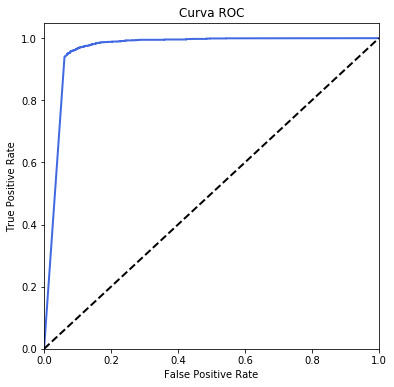

In [14]:
#Exibindo detalhes graficamente
show_results(gnb)

## 2 - Decision Tree

Neste algoritmo foram variados parâmetros relacionados a altura da árvore, 30, 10 e 5, respectivamente. Esses valores foram escolhidos observando o último gráfico desta seção (parameter x accuracy). Ao realizar as variações, observou-se que, ao diminuir a profundidade máxima da árvore, a acurácia aumenta. Isso ocorre devida a árvore ser muito extensa, com isso acaba decorando os dados de treino, logo, na validação, o resultado não é tão bom quanto no treino (overfitting). Os gráficos abaixo exibem a variação da acurácia com base nas variações.

De maneira geral:
- O algoritmo apresentou uma boa precisão para o problema, alcançando uma acurácia de 94,8%, superior ao Naive Bayes.
- Foi variado a altura da árvore. O melhor parâmetro foi: 5 graus de profundidade máxima. Ao observar o último gráfico, observa-se que selecionado a altura 5, o algoritmo apresenta uma taxa de acerto aceitável no treino e uma boa taxa no teste. Isso confirma que nesse ponto, o algoritmo estava generalizando. A partir desse valor a precisão na validação diminui e aumenta apenas no treino, gerando o overfitting. Se considerarmos 10 graus, a precisão na validação cresce, mas não justifica selecioná-lo, pois a diferença da precisão entre 5 e 10 é praticamente insignificante, além de que, com grau de profundidade = 10 o algoritmo passa a quase decorar os dados de treino.
- Por fim, observando a curva ROC, nota-se que a partir que a taxa de True Positivo aumenta, cresce os Falso Positivos. De maneira geral, a quantidade de Falso Positivos é consideravelmente pequena, sendo aceitável para o problema proposto, pois com uma alta precisão, a quantidade de Falso Positivos se mantém baixa.

In [49]:
#Explicar cada parâmetro e explicar detalhadamente os resultados / Normalizar
def calc_decision_tree(max_depth):
    train_acc = []
    val_acc = []
    
    clf = DecisionTreeClassifier(max_depth=max_depth)
    
    for i in range(0, K_FOLD):          
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))        

    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))
    
    return clf, np.average(train_acc), np.average(val_acc)

**2.1 - Variando Parâmetros**

In [50]:
v_decision_acc_train = []
v_decision_acc_test = []

clf, acc_train, acc_test = calc_decision_tree(30)
v_decision_acc_train.append(acc_train)
v_decision_acc_test.append(acc_test)

Média da Acurácia na treino: 1.0
Média da Acurácia na validação: 0.948
Desvio Padrão da Acurácia na treino: 0.0
Desvio Padrão da Acurácia na validação: 0.00567


In [51]:
clf, acc_train, acc_test = calc_decision_tree(10)
v_decision_acc_train.append(acc_train)
v_decision_acc_test.append(acc_test)

Média da Acurácia na treino: 0.992
Média da Acurácia na validação: 0.95
Desvio Padrão da Acurácia na treino: 0.00171
Desvio Padrão da Acurácia na validação: 0.00415


In [52]:
clf, acc_train, acc_test = calc_decision_tree(5)
v_decision_acc_train.append(acc_train)
v_decision_acc_test.append(acc_test)

Média da Acurácia na treino: 0.965
Média da Acurácia na validação: 0.948
Desvio Padrão da Acurácia na treino: 0.00268
Desvio Padrão da Acurácia na validação: 0.00611


**2.2 - Gráficos - Decision Tree**

                precision    recall  f1-score   support

False Positive       0.98      0.95      0.97      3098
     Confirmed       0.93      0.98      0.95      2104

     micro avg       0.96      0.96      0.96      5202
     macro avg       0.96      0.96      0.96      5202
  weighted avg       0.96      0.96      0.96      5202



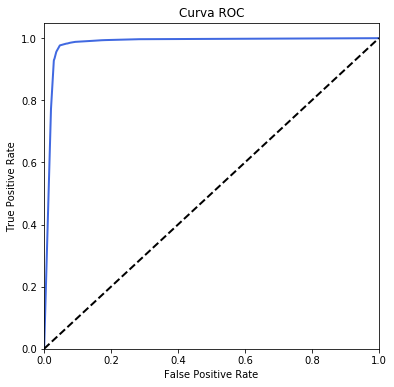

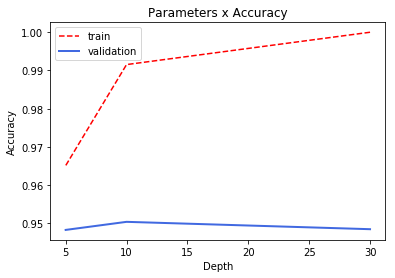

In [53]:
show_results(clf)
plot_accuracyXparams([30, 10, 5], v_decision_acc_train, v_decision_acc_test, "Depth")

## 3 - Support Vector Machine

Neste algoritmo foi variado os parâmetros de kernel (sigmoid, poly, rbf, linear). O kernel no SVM é um dos principais parâmetros, que é responsável por transformar a distribuição dos dados para a classificação. Utilizando o kernel=linear alcançou-se a melhor acurácia (95,2%), um pouco superior ao Decision Tree. No último gráfico é possível observar a acurácia do SVM utilizando cada kernel. 


- Gráfico (parameter x accuracy) - Um fato interessante é que diferente dos outros métodos, o SVM apresentou taxas próximas de acurácia tanto no treino e teste, indicando que o SVM não está "decorando" os dados, sendo assim, possível generalizar com eficiência em todos os kernels.
- Já a curva ROC é um pouco "melhor", no sentido que está bem próxima ao eixo 0. Além de que, a curva mais acentuada ocorre bem próxima ao 1 no eixo y, ou seja, é possível atingir uma alta precisão com poucos erros de Falso Positivo.
- Adicionalmente, o algoritmo tem boas medidas de recall acompanhadas de uma precisão alta. Isso é bom, pois o algoritmo detecta grande parte dos exoplanetas que existem para a classificação.

In [21]:
def calc_svm(kernel):
    train_acc = []
    val_acc = []
    c = 1.0
    clf = svm.SVC(c, kernel, gamma="scale", probability=True)
    
    for i in range(0, K_FOLD):          
        print("Fold " + str(i))
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))
   
    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))   
    
    return clf, np.average(train_acc), np.average(val_acc)

**3.1 - Parâmetros**

In [22]:
v_svm_acc_train = []
v_svm_acc_test = []

clf, acc_train, acc_test = calc_svm("sigmoid")
v_svm_acc_train.append(acc_train)
v_svm_acc_test.append(acc_test)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Média da Acurácia na treino: 0.834
Média da Acurácia na validação: 0.835
Desvio Padrão da Acurácia na treino: 0.0127
Desvio Padrão da Acurácia na validação: 0.0216


In [23]:
clf, acc_train, acc_test = calc_svm("poly")
v_svm_acc_train.append(acc_train)
v_svm_acc_test.append(acc_test)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Média da Acurácia na treino: 0.892
Média da Acurácia na validação: 0.879
Desvio Padrão da Acurácia na treino: 0.00201
Desvio Padrão da Acurácia na validação: 0.00907


In [24]:
clf, acc_train, acc_test = calc_svm("rbf")
v_svm_acc_train.append(acc_train)
v_svm_acc_test.append(acc_test)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Média da Acurácia na treino: 0.943
Média da Acurácia na validação: 0.937
Desvio Padrão da Acurácia na treino: 0.00151
Desvio Padrão da Acurácia na validação: 0.00876


In [25]:
clf, acc_train, acc_test = calc_svm("linear")
v_svm_acc_train.append(acc_train)
v_svm_acc_test.append(acc_test)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Média da Acurácia na treino: 0.955
Média da Acurácia na validação: 0.952
Desvio Padrão da Acurácia na treino: 0.000925
Desvio Padrão da Acurácia na validação: 0.00369


**Resultado**

                precision    recall  f1-score   support

False Positive       0.97      0.95      0.96      3098
     Confirmed       0.93      0.96      0.95      2104

     micro avg       0.96      0.96      0.96      5202
     macro avg       0.95      0.96      0.95      5202
  weighted avg       0.96      0.96      0.96      5202



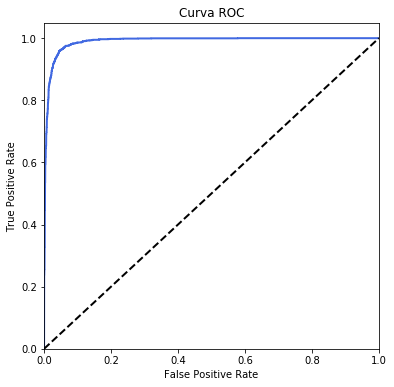

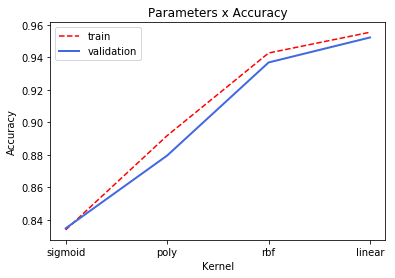

In [26]:
show_results(clf)
plot_accuracyXparams([1, 2, 3, 4], v_svm_acc_train, v_svm_acc_test, "Kernel", ["sigmoid", "poly", "rbf", "linear"])

## 4 - k-NN

Neste algoritmo foi variado a quantidade de vizinhos, ou seja, a quantidade de vizinhos necessários para classificar um ponto para uma classe ou não. De maneira geral: 

- O algoritmo apresentou uma precisão máxima de 89,3%.
- Ao aumentar a quantidade de vizinhos do algoritmos, a precisão foi aumentando. Logo, o melhor parâmetro para a escolha foi k = 10.
- No gráfico (parameter x accuracy), é possível observar que ao aumentar a variável (k), ou seja, a quantidade de vizinhos, a precisão no treino e no teste diminui. Mas ao observar no k = 10, temos um aumento na precisão no teste acompanhado de uma queda no treino, ou seja o algoritmo com esses parâmetros obtém uma boa taxa de aprendizado. A partir de k = 10, o valor da precisão na validação e no treino diminui se aproximando cada vez mais. Por isso a escolha desse valor k=10, pois nesse ponto a precisão do treino diminui mas no teste se mantém praticamente a mesma de k = 5.
- A curva ROC se compararmos com as anteriores, observa-se uma maior inclinação. De certa maneira, com esse algoritmo, obtém-se uma maior quantidade de Falso Positivos do que com os anteriores.

In [27]:
def calc_k_nn(k): 
    train_acc = []
    val_acc = []
    
    print("K = {}".format(k))             
    clf = neighbors.KNeighborsClassifier(n_neighbors=k) 
    
    for i in range(0, K_FOLD):          
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))

    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc))) 
    
    return clf, np.average(train_acc), np.average(val_acc)

**4.1 - Variando Parâmetros**

In [28]:
v_knn_acc_train = []
v_knn_acc_test = []

clf, acc_train, acc_test = calc_k_nn(5)
v_knn_acc_train.append(acc_train)
v_knn_acc_test.append(acc_test)

K = 5
Média da Acurácia na treino: 0.919
Média da Acurácia na validação: 0.896
Desvio Padrão da Acurácia na treino: 0.00211
Desvio Padrão da Acurácia na validação: 0.00845


K = 10
Média da Acurácia na treino: 0.91
Média da Acurácia na validação: 0.893
Desvio Padrão da Acurácia na treino: 0.00131
Desvio Padrão da Acurácia na validação: 0.00692


                precision    recall  f1-score   support

False Positive       0.98      0.86      0.92      3098
     Confirmed       0.82      0.97      0.89      2104

     micro avg       0.91      0.91      0.91      5202
     macro avg       0.90      0.92      0.90      5202
  weighted avg       0.92      0.91      0.91      5202



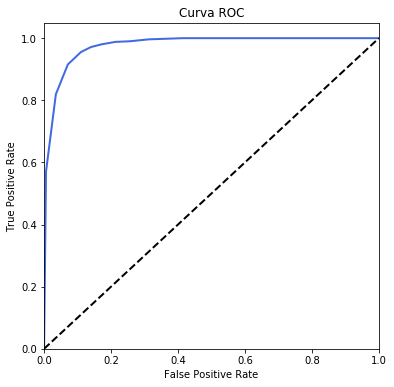

In [29]:
#Melhor parâmetro
clf, acc_train, acc_test = calc_k_nn(10)
v_knn_acc_train.append(acc_train)
v_knn_acc_test.append(acc_test)
print("\n")
show_results(clf)

In [30]:
clf, acc_train, acc_test = calc_k_nn(30)
v_knn_acc_train.append(acc_train)
v_knn_acc_test.append(acc_test)

K = 30
Média da Acurácia na treino: 0.877
Média da Acurácia na validação: 0.872
Desvio Padrão da Acurácia na treino: 0.00283
Desvio Padrão da Acurácia na validação: 0.0101


**4.2 - Gráficos - k-NN**

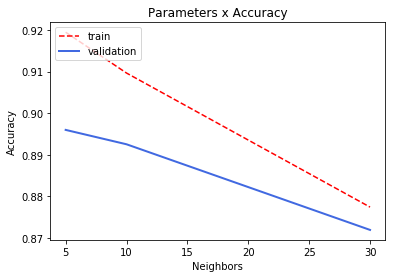

In [31]:

plot_accuracyXparams([5, 10, 30], v_knn_acc_train, v_knn_acc_test, "Neighbors")

## 5 - Random Forest

Neste algoritmo foram variados os parâmetros de: quantidade de árvores e tamanho máximo da árvore. De maneira geral, o algoritmo apresentou uma boa precisão de 96,6%.

De maneira geral:

- Os parâmetros: n_estimators=25, max_depth=10, foram os melhores. Max_depth está relacionado com o tamanho máximo de cada árvore do modelo Random Forest. É importante sempre escolher um tamanho em que o algoritmo não decore os dados. Já n_estimators, está relacionado com a quantidade de árvores do modelo. Por fim, teremos um modelo com 25 árvores com no máximo uma altura de 10.
- É interessante notar que se utilizarmos uma maior quantidade de árvores, a precisão no teste aumenta, mas em contrapartida, o modelo em vez de generalizar, decora o dado, pois a precisão do treino fica em 100%. Além do mais, se observarmos a diferença entre as precisões, nota-se que essa diferença é bem pequena, não justificando a escolha de valores maiores. Por isso, foi escolhido parâmetros com uma precisão um pouco menor (0,02%), mas que não decora os dados. No último gráfico (parameter x accuracy) é possível observar essa variação.
- Além disto, o Random Forest demonstra ser um bom classificador. Ao observar a curva ROC, nota-se que praticamente o gráfico se mantém no x = 0, ou seja, não apresenta Falso Positivo. A curva começa aparecer apenas bem próximo ao y = 1. Assim, é possível afirmar que o Random Forest apresentou a melhor curva até então, apresentando poucos Falso Positivos. Além do mais, se existisse uma restrição que era necessário ter um modelo com poucos Falso Positivos, a melhor escolha seria o Random Forest.

In [32]:
def calc_randomforest(N, max_depth):
    train_acc = []
    val_acc = []
    
    clf = ensemble.RandomForestClassifier(n_estimators=N, max_depth=max_depth)
    
    for i in range(0, K_FOLD):          
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))        

    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))
        
    return clf, np.average(train_acc), np.average(val_acc)

**5.1 - Variando Parâmetros**

In [38]:
v_random_acc_train = []
v_random_acc_test = []

clf, acc_train, acc_test = calc_randomforest(50, None)
v_random_acc_train.append(acc_train)
v_random_acc_test.append(acc_test)

Média da Acurácia na treino: 1.0
Média da Acurácia na validação: 0.969
Desvio Padrão da Acurácia na treino: 0.000107
Desvio Padrão da Acurácia na validação: 0.00529


Média da Acurácia na treino: 0.99
Média da Acurácia na validação: 0.966
Desvio Padrão da Acurácia na treino: 0.00137
Desvio Padrão da Acurácia na validação: 0.00536


                precision    recall  f1-score   support

False Positive       0.99      0.98      0.99      3098
     Confirmed       0.97      0.99      0.98      2104

     micro avg       0.98      0.98      0.98      5202
     macro avg       0.98      0.98      0.98      5202
  weighted avg       0.98      0.98      0.98      5202



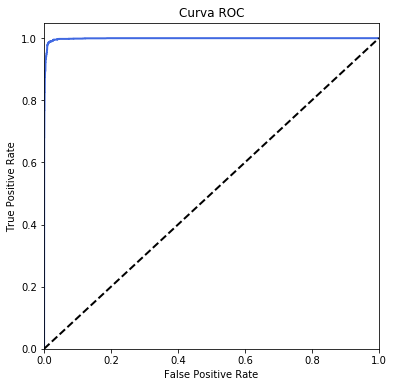

In [39]:
#Melhor Parâmetro
clf, acc_train, acc_test = calc_randomforest(25, 10)
v_random_acc_train.append(acc_train)
v_random_acc_test.append(acc_test)
print("\n")
show_results(clf)

In [40]:
clf, acc_train, acc_test = calc_randomforest(10, 10)
v_random_acc_train.append(acc_train)
v_random_acc_test.append(acc_test)

Média da Acurácia na treino: 0.989
Média da Acurácia na validação: 0.964
Desvio Padrão da Acurácia na treino: 0.0019
Desvio Padrão da Acurácia na validação: 0.00562


**5.2 - Gráficos**

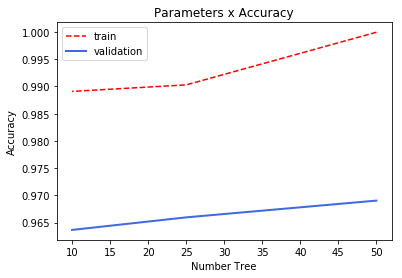

In [41]:
plot_accuracyXparams([50, 25, 10], v_random_acc_train, v_random_acc_test, "Number Tree")

## 6 - Gradiente Tree Boosting

Neste algoritmo, variou-se o parâmetro de iteração (n_estimators). De maneira geral, o algoritmo apresentou um excelente resultado 96,4% de acurácia. O melhor parâmetro para o algoritmo foi: n_estimators = 30. Esse parâmetro significa a quantidade de árvores incluídas no modelo, ou seja, a quantidade de iterações, onde cada árvore é responsável pelos dados que o anterior errou, assim construindo um modelo eficiente.

- No último gráfico, é possível observar que a partir de n_estimators = 30, a precisão na validação não cresce de maneira significativa. Apenas a precisão no treino aumenta, ou seja, começa o overfitting. Assim, escolheu-se 30 como melhor parâmetro, que é o momento em que o algoritmo apresenta uma boa taxa de acerto na validação e não está decorando os dados.

- Além do mais, a curva ROC apresenta bons resultados, no sentido que possui poucos Falso Positivos a medida que a precisão cresce, ficando atrás apenas da curva do Random Forest. 

In [42]:
def calc_gradient_tree_boosting(n_estimators):
    train_acc = []
    val_acc = []
    
    clf = clf = ensemble.GradientBoostingClassifier(n_estimators=n_estimators)
    
    for i in range(0, K_FOLD):          
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))        

    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))
    
    return clf, np.average(train_acc), np.average(val_acc)

**6.1 - Variando Parâmetros**

In [43]:
v_boosting_train = []
v_boosting_test = []

clf, acc_train, acc_test = calc_gradient_tree_boosting(5)
v_boosting_train.append(acc_train)
v_boosting_test.append(acc_test)

Média da Acurácia na treino: 0.951
Média da Acurácia na validação: 0.945
Desvio Padrão da Acurácia na treino: 0.00319
Desvio Padrão da Acurácia na validação: 0.00723


In [44]:
clf, acc_train, acc_test = calc_gradient_tree_boosting(15)
v_boosting_train.append(acc_train)
v_boosting_test.append(acc_test)

Média da Acurácia na treino: 0.963
Média da Acurácia na validação: 0.955
Desvio Padrão da Acurácia na treino: 0.00185
Desvio Padrão da Acurácia na validação: 0.00769


Média da Acurácia na treino: 0.973
Média da Acurácia na validação: 0.964
Desvio Padrão da Acurácia na treino: 0.00119
Desvio Padrão da Acurácia na validação: 0.00731


                precision    recall  f1-score   support

False Positive       0.98      0.97      0.98      3098
     Confirmed       0.96      0.97      0.96      2104

     micro avg       0.97      0.97      0.97      5202
     macro avg       0.97      0.97      0.97      5202
  weighted avg       0.97      0.97      0.97      5202



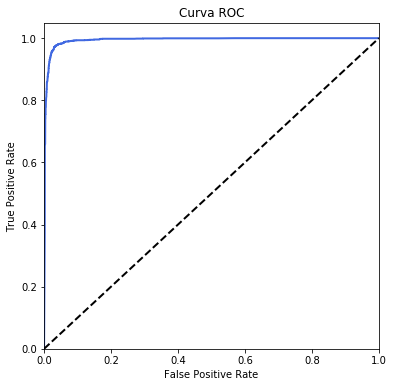

In [45]:
#Melhor parâmetro
clf, acc_train, acc_test = calc_gradient_tree_boosting(30)
v_boosting_train.append(acc_train)
v_boosting_test.append(acc_test)
print("\n")
show_results(clf)

In [46]:
clf, acc_train, acc_test = calc_gradient_tree_boosting(200)
v_boosting_train.append(acc_train)
v_boosting_test.append(acc_test)

Média da Acurácia na treino: 0.998
Média da Acurácia na validação: 0.972
Desvio Padrão da Acurácia na treino: 0.00038
Desvio Padrão da Acurácia na validação: 0.00271


**6.2 - Gráficos**

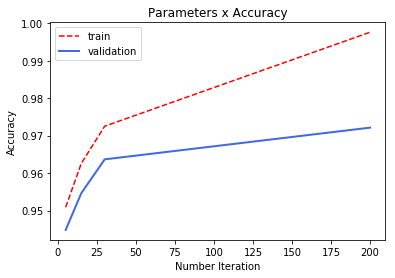

In [47]:
plot_accuracyXparams([5, 15, 30, 200], v_boosting_train, v_boosting_test, "Number Iteration")

## Conclusão

Ao observar os resultados dos algoritmos, pode-se afirmar que de maneira geral, os algoritmos baseados em árvores de decisão apresentaram os melhores resultados (Gradiente Tree Boosting, Random Forest, Decision Tree). Abaixo segue o ranking dos algoritmos.


- 1º - Random Forest (96,6% - std(0.005)) - (n_estimators=25, max_depth=10)
- 2º - Gradiente Tree Boosting (96,4% - std(0.007)) - (n_estimators=30)
- 3º - SVM (95,2% - std(0.003)) - (kernel=linear)
- 4º - Decision Tree (94,8% - std(0.006)) - (k=5)
- 5º - Naive Bayes (91,7% - std(0.006))
- 6º - k-NN (89,3% - std(0.006)) - (n_neighbors=10)

A definição dos melhores algoritmos considerou a acurácia no treino e no teste. Buscando selecionar os parâmetros que permitia que os algoritmos não decorar os dados no treino, ou seja, selecionando os modelos com precisão próxima tanto no treino quanto no teste. Além do mais, os parâmetros foram escolhidos visando obter os parâmetros onde a precisão no treino seja próxima ao teste, indo até os valores em que a precisão da validação estava crescendo. A partir do momento em que a precisão na validação parava de crescer, sabiamos que não faria sentido selecionar parâmetros maiores.

**Gráfico da acurácia dos algoritmos com seus melhores parâmetros**

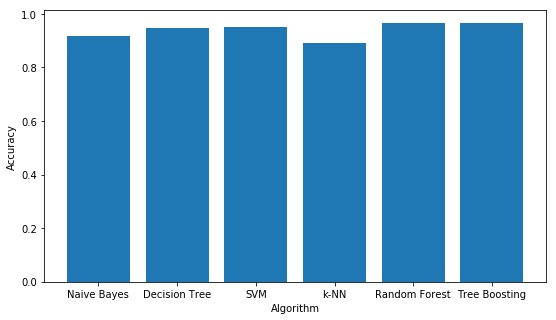

In [54]:
fig, ax = plt.subplots(figsize=(9, 5))
x = [0,1,2,3,4,5]
plt.bar(x, [0.917, 0.948, 0.952, 0.893, 0.966, 0.964])
plt.xticks(x, ('Naive Bayes', 'Decision Tree', 'SVM', 'k-NN', 'Random Forest', 'Tree Boosting'))
plt.ylabel('Accuracy')
plt.xlabel('Algorithm')
plt.show()

Apesar de criarmos o ranking, é difícil afirmar qual modelo de fato é o melhor. Se trazermos para as análises as ferramentas estatísticas, vamos perceber que a diferença entre cada modelo é bem pequena, não sendo suficiente para afirmar com uma precisão qual é o melhor. Se observarmos o desvio padrão de cada resultado, podemos ter uma visão que a variação entre eles é bem pequena. Exceto o k-NN e o Naive Bayes, que teve um desempenho um pouco abaixo, os demais apresentam taxas próximas de precisão. 

De maneira geral, a diferença entre os modelos está na sua abordagem. Naive Bayes com uma abordagem probabilística atingiu uma boa precisão, visto que é um modelo simples. Com isso, podemos induzir que o problema de classificação a ser resolvido não era complexo. Por fim, observando os resultados, os modelos baseados em árvores de decisão foram os melhores algoritmos para o problema de classificação.